### Full Name : Alireza Noori
### Student Number : 402210021


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),  # Convert image to PyTorch tensor
        transforms.Normalize((0,), (1,))  # Z-score normalization (mean, std) for MNIST
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [6]:
def explore_data(data_loader):
    # Get a batch of data
    images, labels = next(iter(data_loader))

    # Plot sample images
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))  # Create a 2x5 grid for 10 images
    fig.suptitle("Sample Images")

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].squeeze(), cmap='gray')  # Plot each image
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')

    plt.show()

    # Plot label distribution
    label_counts = torch.bincount(labels)
    plt.bar(np.arange(len(label_counts)), label_counts.numpy(), tick_label=np.arange(10))
    plt.title("Label Distribution in Batch")
    plt.xlabel("Labels")
    plt.ylabel("Frequency")
    plt.show()
    plt.tight_layout()


Train:


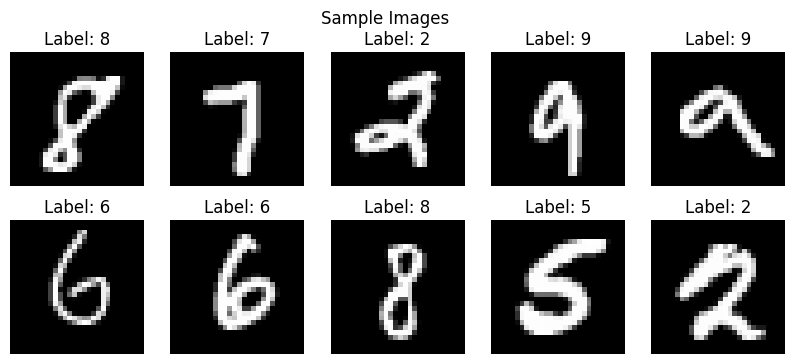

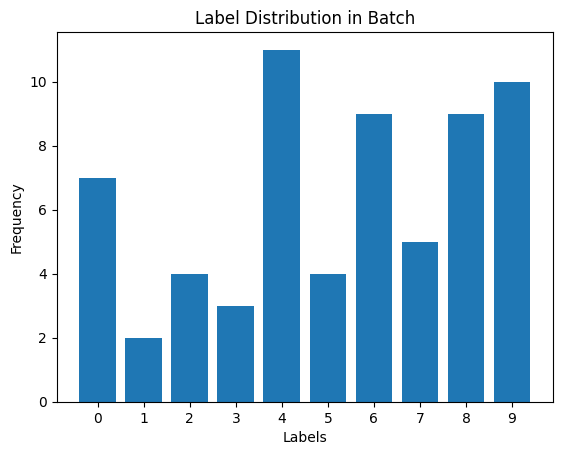

Test:


<Figure size 640x480 with 0 Axes>

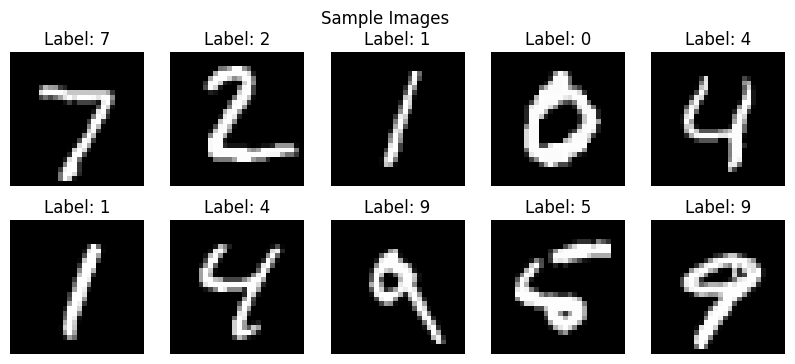

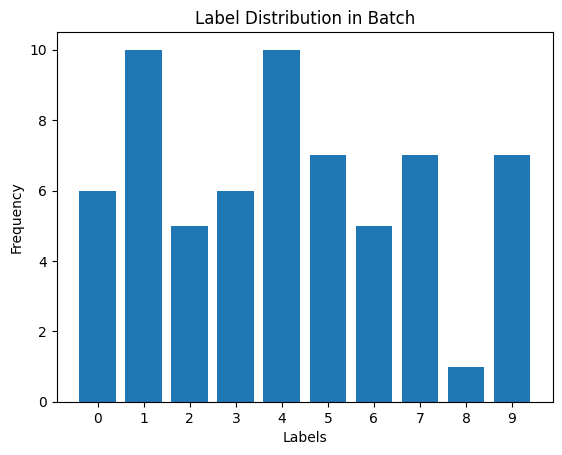

Validation:


<Figure size 640x480 with 0 Axes>

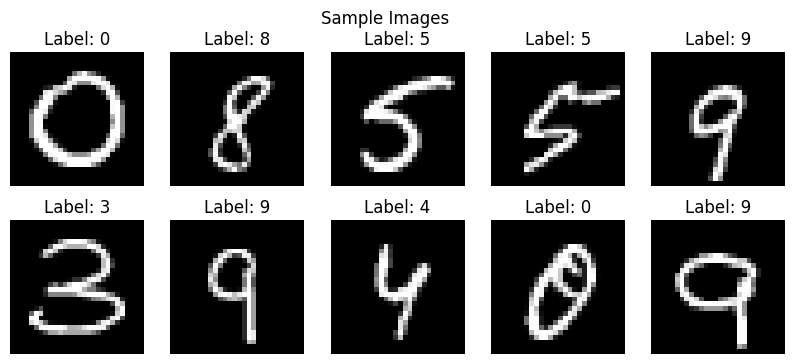

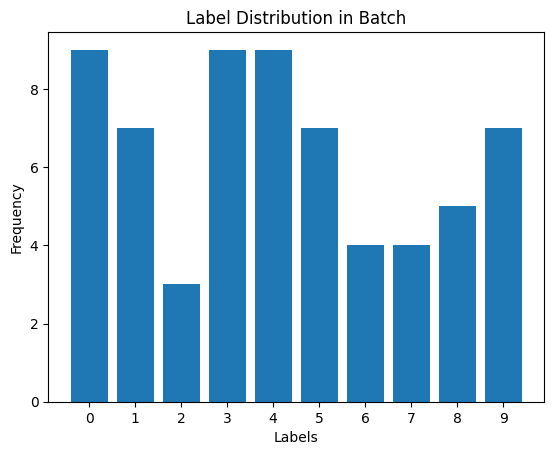

<Figure size 640x480 with 0 Axes>

In [7]:
train_loader, val_loader, test_loader = prepare_data()
print("Train:")
explore_data(train_loader)
print("Test:")
explore_data(test_loader)
print("Validation:")
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [8]:
def prepare_data_for_cart(data_loader):
    flattened_data = []
    labels = []

    for images, batch_labels in data_loader:
        # Flatten each image to a 1D array
        flattened_images = images.view(images.size(0), -1)  # Flatten to (batch_size, 28*28)
        flattened_data.append(flattened_images)
        labels.append(batch_labels)

    # Concatenate all batches into a single tensor
    flattened_data = torch.cat(flattened_data)
    labels = torch.cat(labels)

    return flattened_data, labels

In [9]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

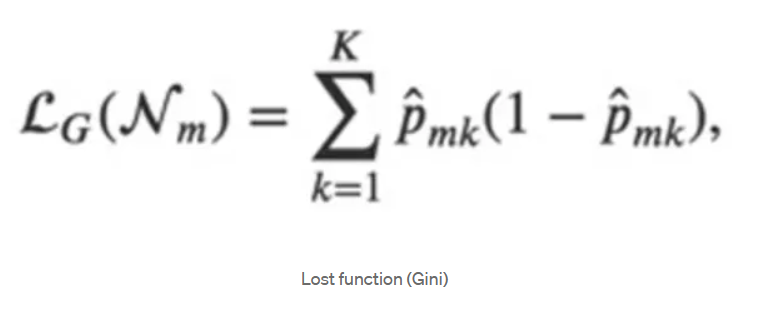

In [10]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Stop conditions
        if len(y) < self.min_samples_split or depth >= self.max_depth:
            return Node(value=self._majority_class(y))

        feature, threshold = self._find_best_split(X, y)
        if feature is None:  # No valid split found
            return Node(value=self._majority_class(y))

        left_indices = X[:, feature] < threshold
        right_indices = X[:, feature] >= threshold

        left_node = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_node = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left_node, right=right_node)

    def _find_best_split(self, X, y):
        best_gini = float('inf')
        best_feature = None
        best_threshold = None
        n_features = X.shape[1]

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_indices = X[:, feature] < threshold
                right_indices = X[:, feature] >= threshold

                if len(y[left_indices]) == 0 or len(y[right_indices]) == 0:
                    continue

                gini = self._calculate_gini_impurity(y[left_indices], y[right_indices])
                if gini < best_gini:
                    best_gini = gini
                    best_feature = feature
                    best_threshold = threshold

        return best_feature, best_threshold

    def _calculate_gini_impurity(self, left_y, right_y):
        total_samples = len(left_y) + len(right_y)
        if total_samples == 0:
            return 0

        left_impurity = self._gini_impurity(left_y)
        right_impurity = self._gini_impurity(right_y)

        weighted_impurity = (len(left_y) / total_samples) * left_impurity + (len(right_y) / total_samples) * right_impurity
        return weighted_impurity

    def _gini_impurity(self, y):
        class_counts = np.bincount(y)
        probabilities = class_counts / len(y)
        return 1 - np.sum(probabilities ** 2)

    def _majority_class(self, y):
        return np.bincount(y).argmax()

    def predict(self, X):
        return [self._predict_sample(sample) for sample in X]

    def _predict_sample(self, sample):
        node = self.root
        while node.value is None:  # Traverse the tree until a leaf is reached
            if sample[node.feature] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.value


## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [ ]:
# Initialize and train your custom CART implementation
tree = DecisionTree_CART(max_depth=5)
tree.fit(X_train.numpy(), y_train.numpy())

# Make predictions on the test set
predictions = tree.predict(X_test.numpy())

# Calculate accuracy
accuracy = np.mean(predictions == y_test.numpy())  # Convert to numpy if needed
print(f"Custom CART Accuracy: {accuracy * 100:.2f}%")

# Now, train Scikit-learn's DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

sk_tree = DecisionTreeClassifier(max_depth=5)
sk_tree.fit(X_train.numpy(), y_train.numpy())  # Convert to numpy if needed

# Make predictions on the test set
sk_predictions = sk_tree.predict(X_test.numpy())

# Calculate accuracy for Scikit-learn's model
sk_accuracy = np.mean(sk_predictions == y_test.numpy())  # Convert to numpy if needed
print(f"Scikit-learn DecisionTreeClassifier Accuracy: {sk_accuracy * 100:.2f}%")


depths = range(1, 11)
custom_accuracies = []
sklearn_accuracies = []
for depth in depths:
    # Train and evaluate custom CART
    tree = DecisionTree_CART(max_depth=depth)
    tree.fit(X_train.numpy(), y_train.numpy())
    custom_preds = tree.predict(X_test.numpy())
    custom_accuracy = np.mean(custom_preds == y_test.numpy())
    custom_accuracies.append(custom_accuracy)

    # Train and evaluate Scikit-learn's DecisionTreeClassifier
    sk_tree = DecisionTreeClassifier(max_depth=depth)
    sk_tree.fit(X_train.numpy(), y_train.numpy())
    sk_preds = sk_tree.predict(X_test.numpy())
    sklearn_accuracy = np.mean(sk_preds == y_test.numpy())
    sklearn_accuracies.append(sklearn_accuracy)

# Plot the accuracy comparison
plt.figure(figsize=(10, 6))
plt.plot(depths, custom_accuracies, label='Custom CART', marker='o')
plt.plot(depths, sklearn_accuracies, label='Scikit-learn DecisionTree', marker='x')
plt.title('Accuracy vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(depths)
plt.grid()
plt.legend()
plt.show()


## Question
What is the difference between ID3 and CART algorithm?

ID3 is a decision tree algorithm used for classification tasks, relying on information gain and primarily suited for categorical data. It doesn't handle continuous variables well and typically produces unpruned trees, which can lead to overfitting. In contrast, CART is used for both classification and regression, using Gini impurity for classification and mean squared error for regression. CART efficiently handles continuous variables, can prune trees to avoid overfitting, and offers greater flexibility in modeling.